In [62]:
import polars as pl
import pyarrow
import torch
from datetime import date, timedelta
from data_pipeline.loader import FluDataLoader
from gluonts.dataset.common import ListDataset
from gluonts.torch import PatchTSTEstimator
from gluonts.evaluation import make_evaluation_predictions
import numpy as np
import matplotlib.pyplot as plt


if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
   

In [2]:
# Load data
fdl = FluDataLoader('data-raw')

combined_dat = fdl.load_data(hhs_kwargs={'rates': True})

/Users/bwrogers/Documents/Research/transformer-flu-forecasting/.venv/lib/python3.10/site-packages/data_pipeline/loader.py:187: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fill_cols] = df[fill_cols].fillna(axis=0, method='ffill')
/Users/bwrogers/Documents/Research/transformer-flu-forecasting/.venv/lib/python3.10/site-packages/data_pipeline/loader.py:187: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fill_cols] = df[fill_cols].fillna(axis=0, method='ffill')
/Users/bwrogers/Documents/Research/transformer-flu-forecasting/.venv/lib/python3.10/site-packages/data_pipeline/loader.py:187: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[fill_cols] = df[fill_cols].fillna(axis=0, method='ffill')
/Users/bwrogers/Docume

We create a list of dictionaries, where each item in the list is one location and one data source to feed to gluonts, and each dictionary contains a `start` date and a `target` time series.

In [53]:
# Filter to only state level data, and non nan incidence.
# Select columns we need for models
state_dat = (pl.DataFrame(combined_dat).
             filter((pl.col("agg_level") == "state") & (pl.col('inc_trans_cs').is_not_nan())).
             select(['location', 'source', 'wk_end_date', 'inc_trans_cs']))

We split the data into training and testing data, with trainging data running up until 3 weeks ago.

In [54]:
max_date = state_dat["wk_end_date"].max()

split_date = max_date - timedelta(days = 100)

print(split_date)

2024-01-18 00:00:00


In [55]:
state_dat_train = state_dat.filter(pl.col("wk_end_date") <= split_date)
state_dat_test = state_dat.filter(pl.col("wk_end_date") > split_date)

Below we define a function to convert the data set into data which can be used with gluonts models.

We create a list of dictionaries, where each item in the list is one location and one data source to feed to gluonts, and each dictionary contains a `start` date and a `target` time series.

In [56]:
def dat_conversion(dataf):
    transformer_dat_list = []

    for state in dataf['location'].unique():
        for data_source in dataf['source'].unique():
        #Filter Dataframe to current state and data source
            state_source_df = dataf.filter((pl.col("location")==state) & (pl.col('source') == data_source))

        #Create the dictionary
            time_series_dict = {
                'target': state_source_df['inc_trans_cs'].to_pandas(),
                'start': state_source_df['wk_end_date'].dt.min()
            }

        # Append the dictionary to the list
            transformer_dat_list.append(time_series_dict)
    
    return(transformer_dat_list)

In [57]:
transformer_train_dat = dat_conversion(state_dat_train)
transformer_test_dat = dat_conversion(state_dat_test)

Use the gluonts ListDataset function to further prepare the data for use with the PatchTST model

In [58]:
train_ds = ListDataset(
    data_iter = transformer_train_dat,
    freq = 'W-SUN'
)

## Model training

In [84]:
estimator = PatchTSTEstimator(prediction_length=8, patch_len=10)

predictor = estimator.train(train_ds[0:5])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/bwrogers/Documents/Research/transformer-flu-forecasting/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PatchTSTModel | 108 K  | train
------------------------------------------------
108 K     Trainable params
320       Non-trainable params
108 K     Total params
0.434     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 0: |          | 50/? [00:04<00:00, 12.44it/s, v_num=5, train_loss=-0.215]

Epoch 0, global step 50: 'train_loss' reached -0.21544 (best -0.21544), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:02<00:00, 19.10it/s, v_num=5, train_loss=-0.54] 

Epoch 1, global step 100: 'train_loss' reached -0.53975 (best -0.53975), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:02<00:00, 19.37it/s, v_num=5, train_loss=-0.607]

Epoch 2, global step 150: 'train_loss' reached -0.60682 (best -0.60682), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:02<00:00, 19.01it/s, v_num=5, train_loss=-0.667]

Epoch 3, global step 200: 'train_loss' reached -0.66749 (best -0.66749), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:02<00:00, 19.36it/s, v_num=5, train_loss=-0.689]

Epoch 4, global step 250: 'train_loss' reached -0.68912 (best -0.68912), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:02<00:00, 19.35it/s, v_num=5, train_loss=-0.685]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |          | 50/? [00:02<00:00, 19.21it/s, v_num=5, train_loss=-0.714]

Epoch 6, global step 350: 'train_loss' reached -0.71442 (best -0.71442), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:02<00:00, 19.19it/s, v_num=5, train_loss=-0.822]

Epoch 7, global step 400: 'train_loss' reached -0.82214 (best -0.82214), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:02<00:00, 19.12it/s, v_num=5, train_loss=-0.777]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:02<00:00, 19.34it/s, v_num=5, train_loss=-0.783]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:02<00:00, 19.25it/s, v_num=5, train_loss=-0.799]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:02<00:00, 19.22it/s, v_num=5, train_loss=-0.874]

Epoch 11, global step 600: 'train_loss' reached -0.87420 (best -0.87420), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:02<00:00, 18.76it/s, v_num=5, train_loss=-0.867]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:02<00:00, 18.53it/s, v_num=5, train_loss=-0.859]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:02<00:00, 18.82it/s, v_num=5, train_loss=-0.873]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:02<00:00, 19.05it/s, v_num=5, train_loss=-0.865]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:02<00:00, 18.29it/s, v_num=5, train_loss=-0.914]

Epoch 16, global step 850: 'train_loss' reached -0.91440 (best -0.91440), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:02<00:00, 19.49it/s, v_num=5, train_loss=-0.943]

Epoch 17, global step 900: 'train_loss' reached -0.94289 (best -0.94289), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:02<00:00, 19.59it/s, v_num=5, train_loss=-0.92] 

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:02<00:00, 19.18it/s, v_num=5, train_loss=-0.966]

Epoch 19, global step 1000: 'train_loss' reached -0.96619 (best -0.96619), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:02<00:00, 19.47it/s, v_num=5, train_loss=-0.938]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:02<00:00, 19.49it/s, v_num=5, train_loss=-0.99] 

Epoch 21, global step 1100: 'train_loss' reached -0.99031 (best -0.99031), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:02<00:00, 19.63it/s, v_num=5, train_loss=-1.02]

Epoch 22, global step 1150: 'train_loss' reached -1.02341 (best -1.02341), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:02<00:00, 19.39it/s, v_num=5, train_loss=-1.01]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:02<00:00, 19.51it/s, v_num=5, train_loss=-0.988]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:02<00:00, 19.65it/s, v_num=5, train_loss=-1.01] 

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:02<00:00, 19.44it/s, v_num=5, train_loss=-1.04]

Epoch 26, global step 1350: 'train_loss' reached -1.03588 (best -1.03588), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:02<00:00, 19.65it/s, v_num=5, train_loss=-1.07]

Epoch 27, global step 1400: 'train_loss' reached -1.07197 (best -1.07197), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:02<00:00, 19.24it/s, v_num=5, train_loss=-1.05]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:02<00:00, 19.06it/s, v_num=5, train_loss=-1.06]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:02<00:00, 19.54it/s, v_num=5, train_loss=-1.08]

Epoch 30, global step 1550: 'train_loss' reached -1.07668 (best -1.07668), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:02<00:00, 19.16it/s, v_num=5, train_loss=-1.11]

Epoch 31, global step 1600: 'train_loss' reached -1.11329 (best -1.11329), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 18: |          | 16/? [10:57<00:00,  0.02it/s, v_num=3, train_loss=-1.15]
Epoch 32: |          | 50/? [00:02<00:00, 19.13it/s, v_num=5, train_loss=-1.07]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:02<00:00, 19.24it/s, v_num=5, train_loss=-1.09]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:02<00:00, 19.00it/s, v_num=5, train_loss=-1.12]

Epoch 34, global step 1750: 'train_loss' reached -1.11945 (best -1.11945), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:02<00:00, 19.06it/s, v_num=5, train_loss=-1.11]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:02<00:00, 19.19it/s, v_num=5, train_loss=-1.14]

Epoch 36, global step 1850: 'train_loss' reached -1.13966 (best -1.13966), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=36-step=1850.ckpt' as top 1


Epoch 37: |          | 50/? [00:02<00:00, 18.38it/s, v_num=5, train_loss=-1.10]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:02<00:00, 19.38it/s, v_num=5, train_loss=-1.11]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:02<00:00, 19.01it/s, v_num=5, train_loss=-1.15]

Epoch 39, global step 2000: 'train_loss' reached -1.15464 (best -1.15464), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:02<00:00, 19.57it/s, v_num=5, train_loss=-1.12]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:02<00:00, 19.46it/s, v_num=5, train_loss=-1.17]

Epoch 41, global step 2100: 'train_loss' reached -1.16561 (best -1.16561), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:02<00:00, 19.52it/s, v_num=5, train_loss=-1.17]

Epoch 42, global step 2150: 'train_loss' reached -1.17469 (best -1.17469), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:02<00:00, 19.44it/s, v_num=5, train_loss=-1.17]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:02<00:00, 19.55it/s, v_num=5, train_loss=-1.15]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:02<00:00, 19.48it/s, v_num=5, train_loss=-1.13]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:02<00:00, 19.61it/s, v_num=5, train_loss=-1.21]

Epoch 46, global step 2350: 'train_loss' reached -1.20610 (best -1.20610), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:02<00:00, 19.40it/s, v_num=5, train_loss=-1.16]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:02<00:00, 19.65it/s, v_num=5, train_loss=-1.15]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:02<00:00, 19.23it/s, v_num=5, train_loss=-1.17]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [00:02<00:00, 19.24it/s, v_num=5, train_loss=-1.19]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: |          | 50/? [00:02<00:00, 19.69it/s, v_num=5, train_loss=-1.17]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:02<00:00, 19.18it/s, v_num=5, train_loss=-1.18]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |          | 50/? [00:02<00:00, 19.56it/s, v_num=5, train_loss=-1.21]

Epoch 53, global step 2700: 'train_loss' reached -1.20954 (best -1.20954), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=53-step=2700.ckpt' as top 1


Epoch 54: |          | 50/? [00:02<00:00, 18.96it/s, v_num=5, train_loss=-1.18]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: |          | 50/? [00:02<00:00, 19.13it/s, v_num=5, train_loss=-1.22]

Epoch 55, global step 2800: 'train_loss' reached -1.22159 (best -1.22159), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=55-step=2800.ckpt' as top 1


Epoch 56: |          | 50/? [00:02<00:00, 19.18it/s, v_num=5, train_loss=-1.23]

Epoch 56, global step 2850: 'train_loss' reached -1.22943 (best -1.22943), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=56-step=2850.ckpt' as top 1


Epoch 57: |          | 50/? [00:02<00:00, 19.34it/s, v_num=5, train_loss=-1.22]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [00:02<00:00, 19.33it/s, v_num=5, train_loss=-1.21]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [00:02<00:00, 19.45it/s, v_num=5, train_loss=-1.22]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [00:02<00:00, 19.41it/s, v_num=5, train_loss=-1.23]

Epoch 60, global step 3050: 'train_loss' reached -1.22952 (best -1.22952), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=60-step=3050.ckpt' as top 1


Epoch 61: |          | 50/? [00:02<00:00, 19.61it/s, v_num=5, train_loss=-1.20]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:02<00:00, 19.25it/s, v_num=5, train_loss=-1.26]

Epoch 62, global step 3150: 'train_loss' reached -1.25806 (best -1.25806), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=62-step=3150.ckpt' as top 1


Epoch 63: |          | 50/? [00:02<00:00, 19.52it/s, v_num=5, train_loss=-1.25]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |          | 50/? [00:02<00:00, 19.12it/s, v_num=5, train_loss=-1.26]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |          | 50/? [00:02<00:00, 19.41it/s, v_num=5, train_loss=-1.23]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [00:02<00:00, 19.27it/s, v_num=5, train_loss=-1.22]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [00:02<00:00, 19.56it/s, v_num=5, train_loss=-1.26]

Epoch 67, global step 3400: 'train_loss' reached -1.26323 (best -1.26323), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=67-step=3400.ckpt' as top 1


Epoch 68: |          | 50/? [00:02<00:00, 19.43it/s, v_num=5, train_loss=-1.28]

Epoch 68, global step 3450: 'train_loss' reached -1.28336 (best -1.28336), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=68-step=3450.ckpt' as top 1


Epoch 69: |          | 50/? [00:02<00:00, 19.53it/s, v_num=5, train_loss=-1.26]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |          | 50/? [00:02<00:00, 19.51it/s, v_num=5, train_loss=-1.27]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [00:02<00:00, 19.39it/s, v_num=5, train_loss=-1.22]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: |          | 50/? [00:02<00:00, 19.59it/s, v_num=5, train_loss=-1.30]

Epoch 72, global step 3650: 'train_loss' reached -1.30147 (best -1.30147), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=72-step=3650.ckpt' as top 1


Epoch 73: |          | 50/? [00:02<00:00, 19.50it/s, v_num=5, train_loss=-1.24]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: |          | 50/? [00:02<00:00, 19.68it/s, v_num=5, train_loss=-1.25]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [00:02<00:00, 19.38it/s, v_num=5, train_loss=-1.28]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [00:02<00:00, 19.27it/s, v_num=5, train_loss=-1.26]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |          | 50/? [00:02<00:00, 19.48it/s, v_num=5, train_loss=-1.27]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [00:02<00:00, 19.39it/s, v_num=5, train_loss=-1.26]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: |          | 50/? [00:02<00:00, 19.62it/s, v_num=5, train_loss=-1.30]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [00:02<00:00, 19.54it/s, v_num=5, train_loss=-1.30]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [00:02<00:00, 19.20it/s, v_num=5, train_loss=-1.31]

Epoch 81, global step 4100: 'train_loss' reached -1.31404 (best -1.31404), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=81-step=4100.ckpt' as top 1


Epoch 82: |          | 50/? [00:02<00:00, 19.64it/s, v_num=5, train_loss=-1.27]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [00:02<00:00, 19.22it/s, v_num=5, train_loss=-1.28]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |          | 50/? [00:02<00:00, 19.78it/s, v_num=5, train_loss=-1.30]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [00:02<00:00, 19.23it/s, v_num=5, train_loss=-1.31]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [00:02<00:00, 19.66it/s, v_num=5, train_loss=-1.30]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |          | 50/? [00:02<00:00, 19.67it/s, v_num=5, train_loss=-1.31]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |          | 50/? [00:02<00:00, 19.20it/s, v_num=5, train_loss=-1.29]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |          | 50/? [00:02<00:00, 19.69it/s, v_num=5, train_loss=-1.31]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |          | 50/? [00:02<00:00, 19.75it/s, v_num=5, train_loss=-1.31]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |          | 50/? [00:02<00:00, 19.50it/s, v_num=5, train_loss=-1.32]

Epoch 91, global step 4600: 'train_loss' reached -1.31609 (best -1.31609), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=91-step=4600.ckpt' as top 1


Epoch 92: |          | 50/? [00:02<00:00, 19.74it/s, v_num=5, train_loss=-1.35]

Epoch 92, global step 4650: 'train_loss' reached -1.35226 (best -1.35226), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=92-step=4650.ckpt' as top 1


Epoch 93: |          | 50/? [00:02<00:00, 19.28it/s, v_num=5, train_loss=-1.34]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |          | 50/? [00:02<00:00, 19.56it/s, v_num=5, train_loss=-1.36]

Epoch 94, global step 4750: 'train_loss' reached -1.35553 (best -1.35553), saving model to '/Users/bwrogers/Documents/Research/transformer-flu-forecasting/lightning_logs/version_5/checkpoints/epoch=94-step=4750.ckpt' as top 1


Epoch 95: |          | 50/? [00:02<00:00, 19.32it/s, v_num=5, train_loss=-1.33]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [00:02<00:00, 19.52it/s, v_num=5, train_loss=-1.35]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |          | 50/? [00:02<00:00, 19.67it/s, v_num=5, train_loss=-1.31]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [00:02<00:00, 19.39it/s, v_num=5, train_loss=-1.33]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |          | 50/? [00:02<00:00, 19.66it/s, v_num=5, train_loss=-1.33]

Epoch 99, global step 5000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:02<00:00, 19.60it/s, v_num=5, train_loss=-1.33]


## Generate predictions for the testing data

In [85]:
test_ds = ListDataset(
    data_iter = transformer_test_dat,
    freq = 'W-SUN'
)

In [86]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset= test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

Convert these two generators to lists for convenience.

In [87]:

forecasts = list(forecast_it)
tss = list(ts_it)

In [88]:
# first entry of the time series list
ts_entry = tss[0]

In [89]:
np.array(ts_entry[:5]).reshape(
    -1,
)

array([ 0.12659697,  0.0932477 ,  0.0656416 , -0.00514456,  0.04628735],
      dtype=float32)

First entry of test dataset

In [90]:
dataset_test_entry = next(iter(test_ds))

First 5 values of test data

In [91]:
dataset_test_entry["target"][:5]

array([ 0.12659697,  0.0932477 ,  0.0656416 , -0.00514456,  0.04628735],
      dtype=float32)

In [92]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [93]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 0.00706929 -0.00867527 -0.01853797 -0.02331174 -0.03132012 -0.04094383
 -0.04794906 -0.04144474]
0.5-quantile (median) of the future window:
 [ 0.00706929 -0.00867527 -0.01853797 -0.02331174 -0.03132012 -0.04094383
 -0.04794906 -0.04144474]


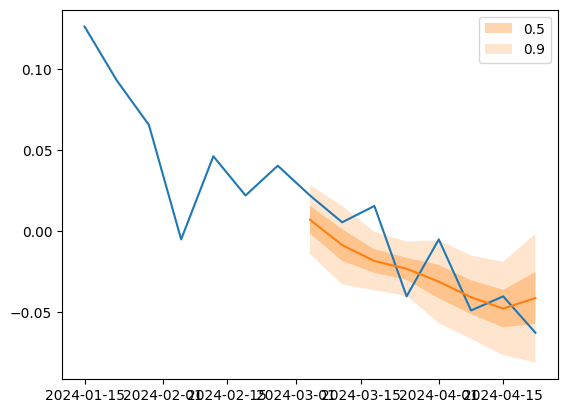

In [97]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()